In [2]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report



base_dir = 'C:\\Users\\91982\\Desktop\\DDoS_Model'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training cat pictures
train_traffic_dir = os.path.join(train_dir, 'Traffic')

# Directory with our training dog pictures
train_normal_dir = os.path.join(train_dir, 'Normal')

# Directory with our validation cat pictures
validation_traffic_dir = os.path.join(validation_dir, 'Traffic')

# Directory with our validation dog pictures
validation_normal_dir = os.path.join(validation_dir, 'Normal')

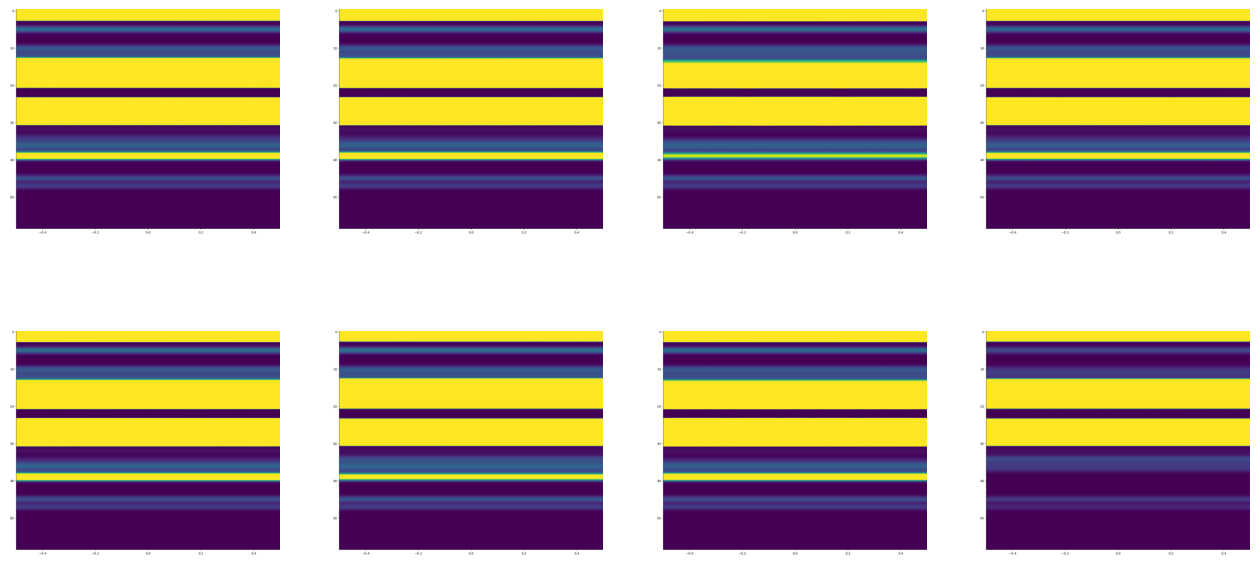

In [3]:
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_traffic_fnames = os.listdir(  )
train_normal_fnames = os.listdir( train_normal_dir )


next_traffic_pix = [os.path.join(train_traffic_dir, fname) 
                for fname in train_traffic_fnames[ pic_index-8:pic_index] 
               ]

next_normal_pix = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_traffic_pix+next_normal_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [5]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [7]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 14634 images belonging to 2 classes.
Found 14634 images belonging to 2 classes.


In [9]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 3)

Epoch 1/3



100/100 [==============================] - 763s 8s/step - loss: 0.4564 - acc: 0.9465 - val_loss: 1.2352e-05 - val_acc: 1.0000
Epoch 2/3
100/100 [==============================] - 716s 7s/step - loss: 0.0251 - acc: 0.9920 - val_loss: 2.7003e-06 - val_acc: 1.0000
Epoch 3/3
100/100 [==============================] - 717s 7s/step - loss: 0.0186 - acc: 0.9935 - val_loss: 4.3053e-06 - val_acc: 1.0000


In [10]:
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size + 1, verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)


732/732 [==============================] - 659s 901ms/step


In [11]:
y_true = validation_generator.classes

# confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_binary)


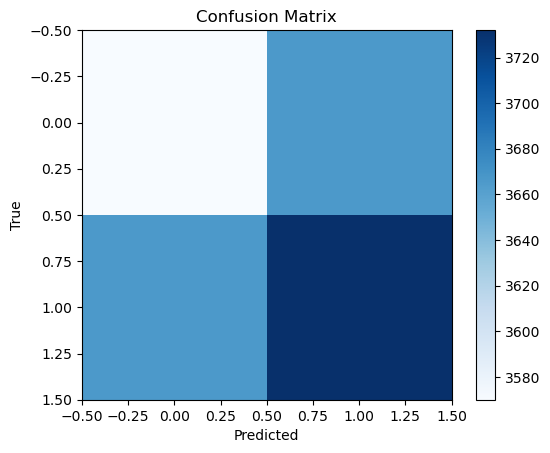

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.49      0.49      7236
           1       0.50      0.50      0.50      7398

    accuracy                           0.50     14634
   macro avg       0.50      0.50      0.50     14634
weighted avg       0.50      0.50      0.50     14634



In [12]:
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y_true, y_pred_binary))

In [13]:
train_accuracy = vgghist.history['acc']
validation_accuracy = vgghist.history['val_acc']


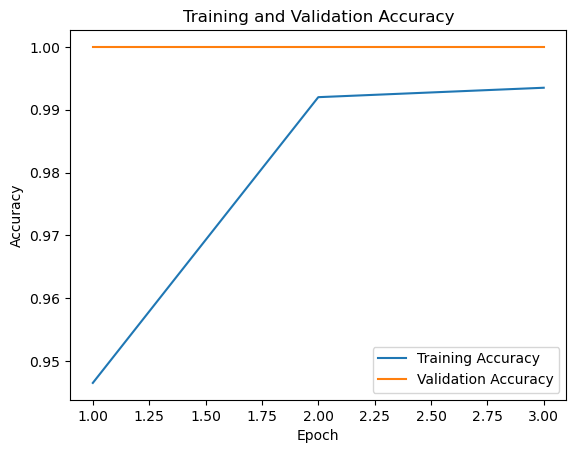

In [14]:
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
eval_result = model.evaluate(validation_generator)

732/732 [==============================] - 643s 878ms/step - loss: 4.3053e-06 - acc: 1.0000


In [16]:
accuracy = eval_result[1]

print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 100.00%


Loss: 0.0000
Accuracy: 1.0000
732/732 [==============================] - 626s 855ms/step
Confusion Matrix:
[[3562 3674]
 [3674 3724]]


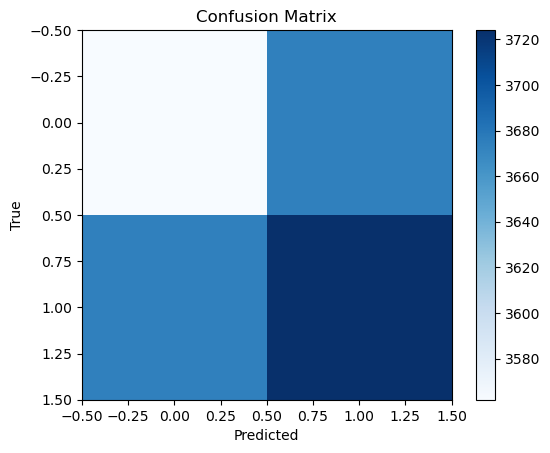

In [17]:


# Get evaluation results
loss = eval_result[0]
accuracy = eval_result[1]

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Predict output on validation set
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size + 1, verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Get true labels
y_true = validation_generator.classes

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_binary)
print('Confusion Matrix:')
print(conf_mat)

# Plot confusion matrix
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


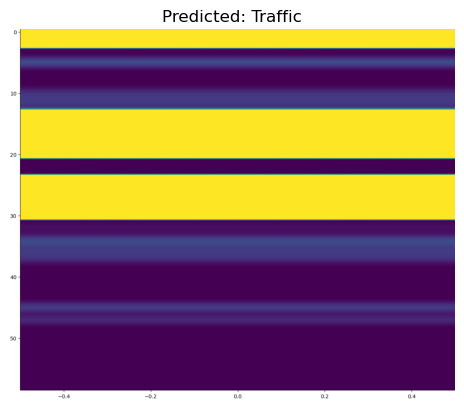

In [18]:
import numpy as np
class_names=['Normal','Traffic']
predicted_class=class_names[int(np.round(y_pred[11]))]

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class}")
plt.show()

In [19]:
import pickle

In [25]:
file_name = "trained_ddos.sav"
pickle.dump(model, open(file_name, 'wb'))